Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO

Установка зависимостей

In [1]:
!pip install tensorflow==1.14 umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!eta install models

Deleting existing directory /usr/local/lib/python3.7/dist-packages/eta/tensorflow/models
Cloning https://github.com/voxel51/models
Cloning into '/usr/local/lib/python3.7/dist-packages/eta/tensorflow/models'...
remote: Enumerating objects: 30876, done.
remote: Total 30876 (delta 0), reused 0 (delta 0), pack-reused 30876
Receiving objects: 100% (30876/30876), 532.07 MiB | 16.94 MiB/s, done.
Resolving deltas: 100% (19430/19430), done.
Installing protobuf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found protoc
Compiling protocol buffers
Installing tf_slim
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installation complete


In [5]:
!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
# import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output
# import tensorflow_models as tfm


Загружать буду через Fiftyone тк он позволяет загрузить только тот сегмент который мне нужен

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


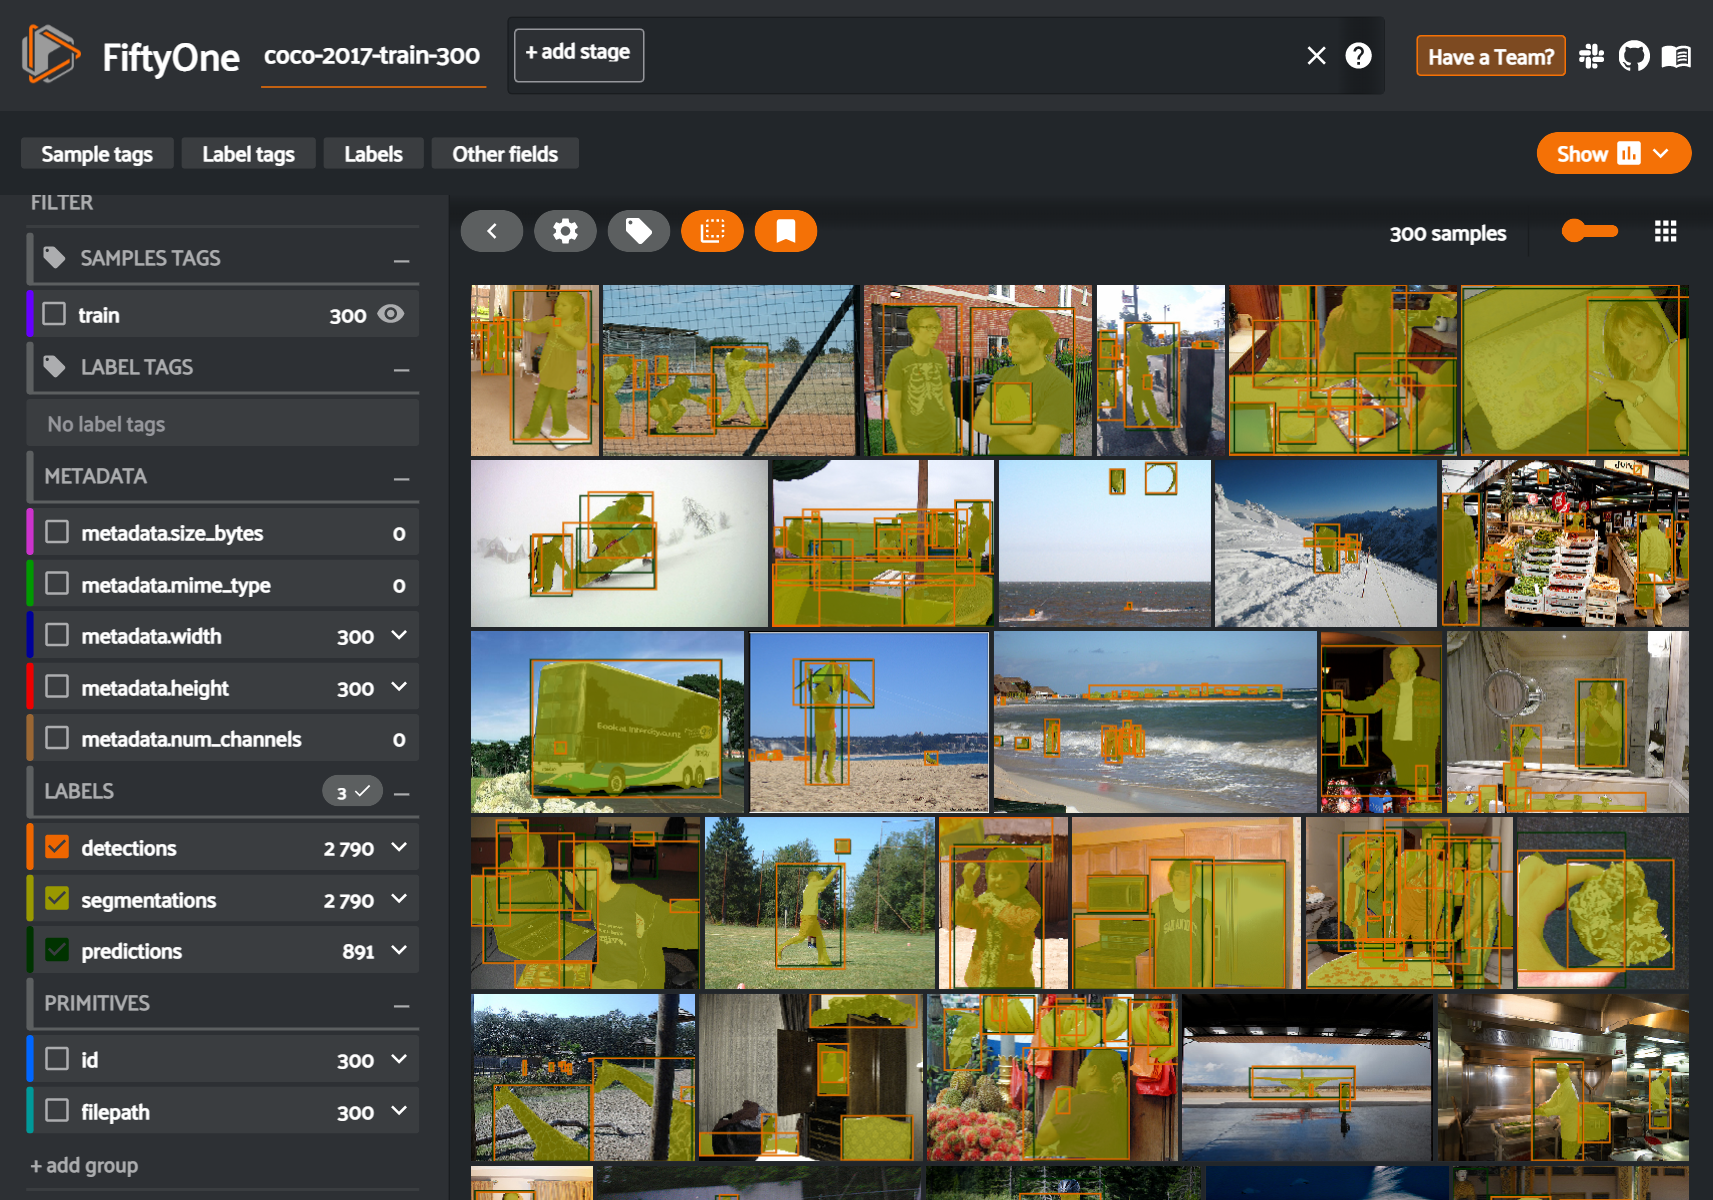

<IPython.core.display.Javascript object>

In [6]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
  "coco-2017", 
  split="train",
  label_types=["detections", "segmentations"],
  classes=["person"],
  shuffle=True,
  seed=51,
  max_samples=300,
)
session = fo.launch_app(dataset)

Модель TensorFlow

In [7]:
model = foz.load_zoo_model("ssd-mobilenet-v1-coco-tf")


In [8]:
dataset.apply_model(model, label_field="predictions", confidence_thresh=0.5)

 100% |█████████████████| 300/300 [55.8s elapsed, 0s remaining, 3.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 300/300 [55.8s elapsed, 0s remaining, 3.4 samples/s]      


Поскольку мы указали эти классы при загрузке набора данных, все изображения гарантированно будут относиться к классам "person", нам просто нужно отфильтровать отдельные метки.

In [9]:
from fiftyone import ViewField as F

oi_classes = ["person"]
coco_classes = ["person"]

eval_view = (
    dataset
    .filter_labels("detections", F("label").is_in(oi_classes), only_matches=False)
    .filter_labels("predictions", F("label").is_in(coco_classes), only_matches=False)
    .map_labels("predictions", {"person": "person"})
)

Оценка

In [14]:
results = eval_view.evaluate_detections(
    "predictions",
    gt_field="detections",
    method="open-images",
)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |█████████████████| 300/300 [4.1s elapsed, 0s remaining, 75.8 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 300/300 [4.1s elapsed, 0s remaining, 75.8 samples/s]      


средняя точность (mAP) для указанного класса.

In [15]:
results.mAP()

0.40914979190388434

Анализ результатов

In [18]:
plot = results.plot_pr_curves()
plot.show()

In [19]:
session = fo.launch_app(view=eval_view)